In [1]:
!pip install git+https://github.com/JoHof/lungmask

import os
import pickle
import numpy as np
import pandas as pd
import pydicom
import re
import seaborn as sns
import warnings
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from plotly.offline import init_notebook_mode
import scipy.ndimage
from skimage.morphology import disk, closing
from tqdm import tqdm
from PIL import Image
from os import listdir
from lungmask import mask
import SimpleITK as sitk

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline
init_notebook_mode(connected=True)


# Set Color Palettes for the notebook (https://color.adobe.com/)
colors_nude = ['#FFE61A','#B2125F','#FF007B','#14B4CC','#099CB3']

# Set Style
sns.set_style("whitegrid")

  Cloning https://github.com/JoHof/lungmask to /tmp/pip-req-build-vl8abclw
  Running command git clone -q https://github.com/JoHof/lungmask /tmp/pip-req-build-vl8abclw
  Created wheel for lungmask: filename=lungmask-0.2.8-py3-none-any.whl size=25333 sha256=8f1b417971fa098cccaa807c7928f72abfe5f310d883f64852cf1ab39203fbd6
  Stored in directory: /tmp/pip-ephem-wheel-cache-jzg70thf/wheels/52/15/e5/5091d6960bade2f75f0d518b4d8234b5d4978eb9ce045300d1
Successfully built lungmask


In [2]:
#### Defining constants and loading data
USE_PICKLED_DATA_TRAIN = True
USE_PICKLED_DATA_TEST = True
N_ITERATIONS = 500
IMAGE_PATH = "../input/osic-pulmonary-fibrosis-progression/"
PICKLE_INPUT_DIR = 'Pickle'
PICKLE_OUTPUT_DIR = 'Pickle'

try:
    os.makedirs(PICKLE_OUTPUT_DIR)
    print("Directory " , PICKLE_OUTPUT_DIR ,  " Created ")
except:
    print("Directory " , PICKLE_OUTPUT_DIR ,  " creation failed")

test_pickle_path = PICKLE_INPUT_DIR + "/testing_df_unique_patients_ct.pkl"
train_pickle_path = PICKLE_INPUT_DIR + "/training_df_unique_patients_ct.pkl"

df_train = pd.read_csv(IMAGE_PATH + 'train.csv')
df_test = pd.read_csv(IMAGE_PATH + 'test.csv')
df_train["dcm_path"] = IMAGE_PATH + "train/" + df_train.Patient + "/"
df_test["dcm_path"] = IMAGE_PATH + "train/" + df_test.Patient + "/"

Directory  Pickle  creation failed


In [3]:
def load_scans(dcm_path):
    try:
        # in this competition we have missing values in ImagePosition, this is why we are sorting by filename number
        files = listdir(dcm_path)
        file_nums = [np.int(file.split(".")[0]) for file in files]
        sorted_file_nums = np.sort(file_nums)[::-1]
        slice_factor = 1
        if 100 <= len(sorted_file_nums) < 300:
            slice_factor = 2
        if 300 <= len(sorted_file_nums):
            slice_factor = 4
        sorted_file_nums = sorted_file_nums[0:len(sorted_file_nums):slice_factor]
        slices = [pydicom.dcmread(dcm_path + "/" + str(file_num) + ".dcm" ) for file_num in sorted_file_nums]
        return slices, slice_factor
    except:
        print('Could not load scans')

def transform_to_hu(slices):
    try:
        images = np.stack([file.pixel_array for file in slices])
        images = images.astype(np.int16)

        # convert ouside pixel-values to air:
        # I'm using <= -1000 to be sure that other defaults are captured as well
        images[images <= -1000] = 0

        # convert to HU
        for n in range(len(slices)):

            intercept = slices[n].RescaleIntercept
            slope = slices[n].RescaleSlope

            if slope != 1:
                images[n] = slope * images[n].astype(np.float64)
                images[n] = images[n].astype(np.int16)

            images[n] += np.int16(intercept)

        return np.array(images, dtype=np.int16)
    except:
        print('error in converting to HU')

def get_window_value(feature):
    try:
        if type(feature) == pydicom.multival.MultiValue:
            return np.int(feature[0])
        else:
            return np.int(feature)
    except:
        print('Could not get window value')

def resample(image, scan, new_spacing=None ):
    try:
        # Determine current pixel spacing
        if new_spacing is None:
            new_spacing = [1,1,1]
        spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float32)

        resize_factor = spacing / new_spacing
        new_real_shape = image.shape * resize_factor
        new_shape = np.round(new_real_shape)
        real_resize_factor = new_shape / image.shape
        new_spacing = spacing / real_resize_factor

        image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')

        return image, new_spacing
    except:
        print('Error in resampling image')

def largest_label_volume(im, bg=-1):
    try:
        vals, counts = np.unique(im, return_counts=True)

        counts = counts[vals != bg]
        vals = vals[vals != bg]

        if len(counts) > 0:
            return vals[np.argmax(counts)]
        else:
            return None
    except:
        print('Could not get largest label volume')

def fill_lungs(binary_image):
    try:
        image = binary_image.copy()
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)

            if l_max is not None: #This slice contains some lung
                image[i][labeling != l_max] = 1
        return image
    except:
        print('Could not fill lungs')

def segment_lung_mask(images_array):
    try:
        segmented_array = np.zeros(images_array.shape)
        width = segmented_array.shape[1]
        height = segmented_array.shape[2]
        masks_array = np.zeros(images_array.shape)
        images_to_be_removed = []

        for n in range(images_array.shape[0]):
            binary_image = np.array(images_array[n] > -320, dtype=np.int8)+1
            labels = measure.label(binary_image)

            background_labels_up = np.unique(labels[0,:])
            background_labels_down = np.unique(labels[-1,:])
            background_labels_left = np.unique(labels[:,0])
            background_labels_right = np.unique(labels[:,-1])
            background_labels = np.concatenate((background_labels_up, background_labels_down, background_labels_left, background_labels_right))
            background_mask = np.isin(labels, background_labels)

            # background_label_1 = labels[0,0]
            # background_label_2 = labels[0,-1]
            # background_label_3 = labels[-1,0]
            # background_label_4 = labels[-1,-1]
            # background_label_5 = labels[0,int(np.ceil(width/2))]
            # background_label_6 = labels[int(np.ceil(height/2)),-1]
            # background_label_7 = labels[-1,int(np.ceil(width/2))]
            # background_label_8 = labels[int(np.ceil(height/2)),-1]


            #Fill the air around the person
            binary_image[background_mask == True] = 2
            # binary_image[background_label_1 == labels] = 2
            # binary_image[background_label_2 == labels] = 2
            # binary_image[background_label_3 == labels] = 2
            # binary_image[background_label_4 == labels] = 2
            # binary_image[background_label_5 == labels] = 2
            # binary_image[background_label_6 == labels] = 2
            # binary_image[background_label_7 == labels] = 2
            # binary_image[background_label_8 == labels] = 2

            binary_image -= 1 #Make the image actual binary
            binary_image = 1-binary_image # Invert it, lungs are now 1

            binary_image = morphology.erosion(binary_image,np.ones([3,3]))
            binary_image = morphology.dilation(binary_image,np.ones([18,18]))
            binary_image = morphology.erosion(binary_image,disk(8))

            if np.mean(binary_image > 0) > 0.02:
                masks_array[n] = binary_image.copy()
                segmented_array[n] = masks_array[n] * images_array[n]
            else:
                images_to_be_removed.append(n)

        segmented_array = np.delete(segmented_array, images_to_be_removed, axis=0)
        print('Original shape: ', images_array.shape, 'Cleaned shape: ', segmented_array.shape)
        return segmented_array, masks_array

    except:
        print('segment lung mask error')

def resize_scan(scan, new_shape):
    try:
        # read slice as 32 bit signed integers
        img = Image.fromarray(scan, mode="I")
        # do the resizing
        img = img.resize(new_shape, resample=Image.LANCZOS)
        # convert back to 16 bit integers
        resized_scan = np.array(img, dtype=np.int16)
        return resized_scan
    except:
        print('Could not resize scan')

def crop_scan(scan):
    try:
        img = Image.fromarray(scan, mode="I")

        left = (scan.shape[0]-512)/2
        right = (scan.shape[0]+512)/2
        top = (scan.shape[1]-512)/2
        bottom = (scan.shape[1]+512)/2

        img = img.crop((left, top, right, bottom))
        # convert back to 16 bit integers
        cropped_scan = np.array(img, dtype=np.int16)
        return cropped_scan
    except:
        print('Could not crop scan')

def crop_and_resize(scan, new_shape):
    try:
        img = Image.fromarray(scan, mode="I")

        left = (scan.shape[0]-512)/2
        right = (scan.shape[0]+512)/2
        top = (scan.shape[1]-512)/2
        bottom = (scan.shape[1]+512)/2

        img = img.crop((left, top, right, bottom))
        img = img.resize(new_shape, resample=Image.LANCZOS)

        cropped_resized_scan = np.array(img, dtype=np.int16)
        return cropped_resized_scan
    except:
        print('Could not crop and resize scan')

def preprocess_to_hu_scans(scan_properties, my_shape, output_dir):
    try:
        for i, patient in enumerate(tqdm(scan_properties.patient.values)):
            pth = scan_properties.loc[scan_properties.patient==patient].patient_pth.values[0]
            slices, slice_factor = load_scans(pth)
            hu_scans = transform_to_hu(slices)
            prepared_scans = np.zeros((hu_scans.shape[0], my_shape[0], my_shape[1]), dtype=np.int16)

            # if squared:
            if hu_scans.shape[1] == hu_scans.shape[2]:

                # if size is as desired
                if hu_scans.shape[1] == my_shape[0]:
                    continue
                # else resize:
                else:
                   # as we have not converted to jpeg to keep all information, we need to do a workaround
                    hu_scans = hu_scans.astype(np.int32)
                    for s in range(hu_scans.shape[0]):
                        prepared_scans[s] = resize_scan(hu_scans[s,:,:], my_shape)

            # if non-squared - do a center crop to 512, 512 and then resize to desired shape
            else:
                hu_scans = hu_scans.astype(np.int32)
                for s in range(hu_scans.shape[0]):
                    # if desired shape is 512x512:
                    if my_shape[0]==512:
                        prepared_scans[s] = crop_scan(hu_scans[s,:,:])
                    else:
                        prepared_scans[s] = crop_and_resize(hu_scans[s,:,:], my_shape)

            # save the prepared scans of patient:
            np.save(output_dir + "/" + patient + '_hu_scans', prepared_scans)
    except:
        print('Could not preprocess to HU')

def get_lung_pixels_and_slices(patient_path):
    try:
        slices, slice_factor = load_scans(patient_path)
        hu_scans = transform_to_hu(slices)
        segmented_array, masks_array = segment_lung_mask(hu_scans)

        return np.count_nonzero(segmented_array), segmented_array.shape[0]
    except:
        print('error for patient', patient_path)

def create_scan_properties_df(df_raw, n):
    try:
        if n is None:
            n = df_raw.Patient.unique().shape[0]

        pixelspacing_r = []
        pixelspacing_c = []
        slice_thicknesses = []
        patient_id = []
        patient_pth = []
        row_values = []
        column_values = []
        window_widths = []
        window_levels = []

        patients = df_raw.Patient.unique()[0:n]

        for patient in patients:
            patient_id.append(patient)
            path = df_raw[df_raw.Patient == patient].dcm_path.values[0]

            example_dcm = listdir(path)[0]
            patient_pth.append(path)
            dataset = pydicom.dcmread(path + "/" + example_dcm)

            window_widths.append(get_window_value(dataset.WindowWidth))
            window_levels.append(get_window_value(dataset.WindowCenter))

            spacing = dataset.PixelSpacing
            slice_thicknesses.append(dataset.SliceThickness)

            row_values.append(dataset.Rows)
            column_values.append(dataset.Columns)
            pixelspacing_r.append(spacing[0])
            pixelspacing_c.append(spacing[1])

        scan_properties = pd.DataFrame(data=patient_id, columns=["patient"])
        scan_properties.loc[:, "rows"] = row_values
        scan_properties.loc[:, "columns"] = column_values
        scan_properties.loc[:, "area"] = scan_properties["rows"] * scan_properties["columns"]
        scan_properties.loc[:, "pixelspacing_r"] = pixelspacing_r
        scan_properties.loc[:, "pixelspacing_c"] = pixelspacing_c
        scan_properties.loc[:, "pixelspacing_area"] = scan_properties.pixelspacing_r * scan_properties.pixelspacing_c
        scan_properties.loc[:, "slice_thickness"] = slice_thicknesses
        scan_properties.loc[:, "patient_pth"] = patient_pth
        scan_properties.loc[:, "window_width"] = window_widths
        scan_properties.loc[:, "window_level"] = window_levels

        scan_properties["r_distance"] = scan_properties.pixelspacing_r * scan_properties.rows
        scan_properties["c_distance"] = scan_properties.pixelspacing_c * scan_properties["columns"]
        scan_properties["area_cm2"] = 0.1* scan_properties["r_distance"] * 0.1*scan_properties["c_distance"]
        scan_properties["slice_volume_cm3"] = 0.1*scan_properties.slice_thickness * scan_properties.area_cm2

        scan_properties["lung_pixels_and_slices"] = scan_properties.apply(lambda x: get_lung_pixels_and_slices(x.patient_pth), axis=1)
        return scan_properties
    except:
        print('Could not create scan properties')

def read_dicom(patient_id, picture_id):
    # read a dcm file for a particular patient
    dcm_file_path = IMAGE_PATH + 'train/' + str(patient_id) + '/' + str(picture_id) + '.dcm'
    dcm = None
    try:
        dcm = pydicom.read_file(dcm_file_path)
    except:
        print('Could not read dicom file {} of patient {}'.format(picture_id, patient_id))
    return dcm

def get_all_patient_datasets(patient_id, patient_dir='train'):
    directory = IMAGE_PATH + patient_dir + "/" + patient_id
    datasets = []

    # First Order the files in the dataset
    files = []
    for dcm in list(os.listdir(directory)):
        files.append(dcm)
    if len(files) == 0:
        print('No datasets found for patient {} in directory {}'.format(patient_id, patient_dir))
        return None
    files.sort(key=lambda f: int(re.sub('\D', '', f)))
    # Read in the Dataset
    for dcm in files:
        path = directory + "/" + dcm
        try:
            datasets.append(pydicom.dcmread(path))
        except:
            print('Could not read dicom file for patient {} in directory {}'.format(patient_id, patient_dir))
            continue

    return datasets

def get_patient_id(dcm):
    if (0x0010, 0x0020) not in dcm:
        return None
    return dcm[0x0010, 0x0020].value

def get_slice_location(dcm):
    if (0x0020, 0x1041) not in dcm:
        print('Key for "Slice Location" does not exist')
        return None
    return float(dcm[0x0020, 0x1041].value)

def get_slice_thickness(dcm):
    if (0x0018, 0x0050) not in dcm:
        print('Key for "Slice Thickness" does not exist')
        return None
    return np.abs(float(dcm[0x0018, 0x0050].value))

def get_pixel_spacings(dcm):
    """
    :param dcm:
    :return: list of two values: [row_spacing, column_spacing]
    """
    if (0x0028, 0x0030) not in dcm:
        return None
    return dcm[0x0028, 0x0030].value

def get_slice_distance(patient_id: str, patient_dir='train'):
    datasets = get_all_patient_datasets(patient_id, patient_dir)
    if len(datasets) < 2:
        print('Less than 2 datasets available for patient {} in directory {}'.format(patient_id, patient_dir))
        return None

    i = 0
    while i < len(datasets):
        if not get_slice_location(datasets[i]) or not get_slice_location(datasets[i+1]):
            i += 1
            continue
        distance = np.abs(get_slice_location(datasets[i]) - get_slice_location(datasets[i+1]))
        if distance > 20:
            i += 1
            continue
        if distance > 0:
            return distance
        i += 1
        continue

    # if get_slice_location does not return anything useful, continue with get_slice_thickness
    i = 0
    while i < len(datasets):
        if not get_slice_thickness(datasets[i]) or get_slice_thickness(datasets[i]) > 20:
            i += 1
            continue
        distance = get_slice_thickness(datasets[i])
        if distance > 0:
            return distance
        i += 1
        continue

    print('Could not get valid slice distance')
    return None

def get_square_mm_per_pixel(patient_id: str, patient_dir='train'):
    datasets = get_all_patient_datasets(patient_id, patient_dir)
    if not datasets or len(datasets) == 0:
        return None
    if not get_pixel_spacings(datasets[0]):
        return None
    spacings = get_pixel_spacings(datasets[0])
    return spacings[0] * spacings[1]

def get_tissue_pixels(applied_mask, img_cropped):
    try:
        black_filter = (applied_mask > 0.2) & (applied_mask < 0.7)
        non_black = img_cropped[black_filter]
    except:
        print('Could not filter tissue')
        return 0
    return len(non_black)

def make_lungmask(img, display=False):
    try:
        # https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/
        img = crop_borders(img)
        row_size= img.shape[0]
        col_size = img.shape[1]
        mean = np.mean(img)
        std = np.std(img)
        img = img-mean
        img = img/std

        # Find the average pixel value near the lungs to renormalize washed out images
        middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)]
        mean = np.mean(middle)
        max = np.max(img)
        min = np.min(img)

        # To improve threshold finding, I'm moving the underflow and overflow on the pixel spectrum
        img[img==max]=mean
        img[img==min]=mean

        # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
        kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
        centers = sorted(kmeans.cluster_centers_.flatten())
        threshold = np.mean(centers)
        thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

        # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.
        # We don't want to accidentally clip the lung.

        eroded = morphology.erosion(thresh_img,np.ones([3,3]))
        dilation = morphology.dilation(eroded,np.ones([8,8]))

        labels = measure.label(dilation) # Different labels are displayed in different colors
        regions = measure.regionprops(labels)

        good_labels = []
        for prop in regions:
            B = prop.bbox
            height_check = row_size * 0.1 < B[2]-B[0] < row_size * 0.8
            width_check = col_size * 0.1 < B[3]-B[1] < col_size * 0.8
            position_row_check = B[0] > row_size * 0.2
            position_column_check = B[2] < col_size * 0.8
            if height_check and width_check and position_row_check and position_column_check:
                good_labels.append(prop.label)
            if len(good_labels) > 4:
                print('Lung mask contains more than 4 areas.')
                return False

        if len(good_labels) < 2:
            print('Lung mask contains less than 2 areas.')
            return False
        mask = np.ndarray([row_size,col_size],dtype=np.int8)
        mask[:] = 0

        #  After just the lungs are left, we do another large dilation
        #  in order to fill in and out the lung mask

        for N in good_labels:
            mask = mask + np.where(labels==N,1,0)
        mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
        if np.all(mask == 0):
            print('Black Image')
            return False
        applied_mask = mask*img
        tissue_only = np.where((applied_mask > 0.2) & (applied_mask < 0.7), 1, 0)

        if (display):
            fig, ax = plt.subplots(4, 2, figsize=[12, 12])
            ax[0, 0].set_title("Original")
            ax[0, 0].imshow(img, cmap='gray')
            ax[0, 0].axis('off')
            ax[0, 1].set_title("Threshold")
            ax[0, 1].imshow(thresh_img, cmap='gray')
            ax[0, 1].axis('off')
            ax[1, 0].set_title("After Erosion and Dilation")
            ax[1, 0].axis('off')
            ax[1, 0].imshow(dilation, cmap='gray')
            ax[1, 1].set_title("Color Labels")
            ax[1, 1].imshow(labels)
            ax[1, 1].axis('off')
            ax[2, 0].set_title("Final Mask")
            ax[2, 0].imshow(mask, cmap='gray')
            ax[2, 0].axis('off')
            ax[2, 1].set_title("Apply Mask on Original")
            ax[2, 1].imshow(mask*img, cmap='gray')
            ax[2, 1].axis('off')
            ax[3, 0].set_title("Tissue only")
            ax[3, 0].imshow(tissue_only, cmap='inferno')
            ax[3, 0].axis('off')
            plt.show()
        return img, applied_mask, mask
    except:
        return img, img, img

def calculate_lung_data(patient_id, segmented_array, mask_array, patient_dir='train', slice_factor=1):
    try:
        total_lung_pixels = np.count_nonzero(mask_array != 0)
        tissue_within_lung_pixels = np.count_nonzero((30 < segmented_array) & (segmented_array < 70))
        print(total_lung_pixels, tissue_within_lung_pixels)

        mm2_per_pixel = get_square_mm_per_pixel(patient_id, patient_dir=patient_dir)
        slice_distance = get_slice_distance(patient_id, patient_dir=patient_dir) * slice_factor
        mm3_per_pixel = mm2_per_pixel * slice_distance

        fibrotic_volume_cm3 = np.ceil((tissue_within_lung_pixels * mm3_per_pixel) / 1000)
        lung_volume_cm3 = np.ceil((total_lung_pixels * mm3_per_pixel) / 1000)

        return lung_volume_cm3, fibrotic_volume_cm3
    except:
        return None, None

def crop_borders(img):
    try:
        img = img[~np.all(img == img[0,:], axis=1)]
        img = img[:,~np.all(img == img[0,:], axis=0)]
    except:
        print('Could not crop borders')
    return img

def plot_all_patient_images(patient_id, only_mask=True, patient_dir='train'):
    datasets = get_all_patient_datasets(patient_id, patient_dir)
    columns = 10
    rows = int(np.ceil(len(datasets) / 10))
    fig=plt.figure(figsize=(16, rows * 2))

    for i in range(1, len(datasets) +1):
        img, applied_mask, mask = None
        try:
            img, applied_mask, mask = make_lungmask(datasets[i-1].pixel_array)[1]
        except AttributeError:
            print('Could not make lung mask of picture', i)
        if only_mask:
            displayed_img = mask
        else:
            displayed_img = applied_mask

        if displayed_img is not None :
            fig.add_subplot(rows, columns, i)
            plt.imshow(displayed_img)
            plt.title(i, fontsize = 9)
            plt.axis('off')

def show_all_masks(patient_id, picture_id):
    # Show all masks of one picture
    dataset = read_dicom(patient_id, picture_id)

    img = dataset.pixel_array
    # Masked image
    make_lungmask(img, display=True)
    # except:
    #     print('Could not convert image to pixels')

def cat_to_binary(value, cat_name):
    if value == cat_name:
        return 1
    else:
        return 0

def laplace_log_likelihood(actual_fvc, predicted_fvc, confidence, return_values = False):
    """
    Calculates the modified Laplace Log Likelihood score for this competition.
    """
    try:
        sd_clipped = np.maximum(confidence, 70)
        delta = np.minimum(np.abs(actual_fvc - predicted_fvc), 1000)
        metric = - np.sqrt(2) * delta / sd_clipped - np.log(np.sqrt(2) * sd_clipped)

        if return_values:
            return metric
        else:
            return np.mean(metric)
    except:
        print('Could not calculate LLL')
        return 0

def calculate_gradient_coef_for_patient(patient_records_df):
    X_train = patient_records_df[['Weeks']]
    y_train = patient_records_df[['FVC']]
    try:
        model = LinearRegression(normalize=True).fit(X_train, y_train)
        return model.coef_[0][0]
    except:
        print('Could not fit LinearRegression model')
        return 0

def prepare_patient_data(df_raw, patient_id, df_new):
    try:
        # Filter by single patients
        patient_records_df = df_raw[df_raw.Patient == patient_id]
        number_records = len(patient_records_df)
        gradient_coef = calculate_gradient_coef_for_patient(patient_records_df)
        max_fvc = patient_records_df[['FVC']].max()[0]
        min_fvc = patient_records_df[['FVC']].min()[0]
        std_fvc = patient_records_df[['FVC']].std()[0]
        if np.isnan(std_fvc):
            std_fvc = 0

        first_measurement = patient_records_df.iloc[0]
        last_measurement = patient_records_df.iloc[number_records - 1]
        diff_abs_fvc = last_measurement['FVC'] - first_measurement['FVC']
        # print('L {} - F {} = {}'.format(last_measurement['FVC'], first_measurement['FVC'], diff_abs_fvc))
        df_unique_patient = pd.DataFrame(
            index=[patient_id],
            columns=[
                'FVC_First',
                'FVC_Last',
                'Diff_FVC_Abs',
                'Gradient_Coef',
                'Max_FVC',
                'Min_FVC',
                'Std_FVC'
            ],
            data=[[
                first_measurement['FVC'],
                last_measurement['FVC'],
                diff_abs_fvc,
                gradient_coef,
                max_fvc,
                min_fvc,
                std_fvc]]
        )
        df_unique_patient['First_Week'] = first_measurement['Weeks']
        df_unique_patient['Percent'] = first_measurement['Percent']
        df_unique_patient['Age'] = first_measurement['Age']
        df_unique_patient['Sex'] = first_measurement['Sex']
        df_unique_patient['SmokingStatus'] = first_measurement['SmokingStatus']
        df_unique_patient['dcm_path'] = first_measurement['dcm_path']
        df_unique_patient['Male'] = cat_to_binary(first_measurement['Sex'], 'Male')
        df_unique_patient['Female'] = cat_to_binary(first_measurement['Sex'], 'Female')
        df_unique_patient['NeverSmoked'] = cat_to_binary(first_measurement['SmokingStatus'], 'Never smoked')
        df_unique_patient['ExSmoker'] = cat_to_binary(first_measurement['SmokingStatus'], 'Ex-smoker')
        df_unique_patient['CurrentlySmokes'] = cat_to_binary(first_measurement['SmokingStatus'], 'Currently smokes')
        df_unique_patient['lung_volume_cm3'] = 0
        df_unique_patient['percentage_fibrotic_tissue'] = 0

        df_new = df_new.append(df_unique_patient)
        return df_new
    except:
        print('Could not prepare patient data for patient {}'.format(patient_id))
        return df_new

def prepare_unique_patients_train_df(df_train):
    try:
        df_unique_patients = pd.DataFrame(
            columns=[
                'First_Week',
                'FVC_First',
                'FVC_Last',
                'Diff_FVC_Abs',
                'Gradient_Coef',
                'Max_FVC',
                'Min_FVC',
                'Std_FVC',
                'Percent',
                'Age',
                'Sex',
                'SmokingStatus',
                'dcm_path',
                'Male',
                'Female',
                'NeverSmoked',
                'ExSmoker',
                'CurrentlySmokes',
                'lung_volume_cm3',
                'percentage_fibrotic_tissue'
            ])
        unique_patient_ids = df_train['Patient'].unique()
        for patient_id in unique_patient_ids:
            df_unique_patients = prepare_patient_data(df_train, patient_id, df_unique_patients)
        return df_unique_patients
    except:
        print('Could not prepare unique patients dataframe')
        return None

def prepare_unique_patients_test_df(df_test):
    try:
        df_test = df_test.set_index('Patient')
        df_test['Male'] = df_test.apply (lambda x: cat_to_binary(x['Sex'], 'Male'), axis=1)
        df_test['Female'] = df_test.apply (lambda x: cat_to_binary(x['Sex'], 'Female'), axis=1)
        df_test['NeverSmoked'] = df_test.apply (lambda x: cat_to_binary(x['SmokingStatus'], 'Never smoked'), axis=1)
        df_test['ExSmoker'] = df_test.apply (lambda x: cat_to_binary(x['SmokingStatus'], 'Ex-smoker'), axis=1)
        df_test['CurrentlySmokes'] = df_test.apply (lambda x: cat_to_binary(x['SmokingStatus'], 'Currently smokes'), axis=1)
        df_test['lung_volume_cm3'] = 0
        df_test['percentage_fibrotic_tissue'] = 0
        return df_test
    except:
        print('Could not prepare test unique patients dataframe')
        return None

def prepare_boosting_data_x(df_unique_patients: pd.DataFrame):
    # Prepare unique patients an make them suitable for gradient boosting model
    df_copy = df_unique_patients.copy()
    try:
        x = df_copy[[
            'Percent',
            'Age',
            'Male',
            'Female',
            'NeverSmoked',
            'ExSmoker',
            'CurrentlySmokes',
            'lung_volume_cm3',
            'percentage_fibrotic_tissue'
        ]].to_numpy()

        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        return  x_scaled
    except:
        calculate_public_board_lll(df_test, df_train, create_debug_submission(df_test, 2000, 800))
        print('Could not prepare boosting data x')
        return None

def prepare_boosting_data_y(df_unique_patients: pd.DataFrame):
    try:
        df_copy = df_unique_patients.copy()
        df_copy.dropna(inplace=True)
        return df_copy[['Gradient_Coef']].values.ravel()
    except:
        print('Could not prepare boosting data y')
        return None

def test_boost_performance(df_train: pd.DataFrame, test_patients, mean_std_fvc, std_dev_multiplier = 5):
    """
    Create test submission values to check LLL on test split
    Takes in the coefficients of the test group of the boost model split and calculates LLL based on the
    full df_train with all measurements
    :param df_train: All train measurements of all patients. Is needed to get all measurements of the
                        test candidates
    :param test_patients: A patient dataframe (unique patients) from the test split
    :param y_test_predicted: Linear gradient coefficients for each test patient
    """
    test_patient_ids = list(test_patients.index.values)
    df_test_patient_measurements = df_train[df_train.Patient.isin(test_patient_ids)]
    lll_total = 0

    for index, row in df_test_patient_measurements.iterrows():
        week = row['Weeks']
        first_measurement = test_patients.loc[row.Patient]
        patient_id = row['Patient']
        patient_sample_fvc = first_measurement['FVC_First']
        patient_sample_week = first_measurement['First_Week']
        coef_predicted = first_measurement['Gradient_Predicted']
        predicted_fvc = np.round(patient_sample_fvc + (week - patient_sample_week) * coef_predicted, 0)
        std_dev = np.round(mean_std_fvc * std_dev_multiplier * np.abs(week - patient_sample_week) / 145)
        lll = laplace_log_likelihood(row['FVC'], predicted_fvc, std_dev)
        # print('{} FVC real: {} FVC predicted: {} StdDev: {} LLL: {}'.format(patient_id, row['FVC'], predicted_fvc, std_dev, lll))
        lll_total += lll
    return lll_total / len(df_test_patient_measurements)

def calculate_public_board_lll(df_test, df_train, df_submission):
    try:
        test_patient_ids = list(df_test['Patient'])
        last_n_results = 3
        lll_total = 0
        predicted_fvc = 0
        for patient_id in test_patient_ids:
            df_patient = df_train[df_train['Patient'] == patient_id].tail(last_n_results)
            for index, row in df_patient.iterrows():
                week = row['Weeks']
                predicted_fvc = float(df_submission.loc[df_submission['Patient_Week'] == patient_id + '_' + str(week)]['FVC'].values[0])
                confidence = float(df_submission.loc[df_submission['Patient_Week'] == patient_id + '_' + str(week)]['Confidence'].values[0])
                lll = laplace_log_likelihood(row['FVC'], predicted_fvc, confidence, return_values = True)
                lll_total += lll
        print('Public Board LLL', predicted_fvc, lll_total / (len(test_patient_ids) * last_n_results))
    except:
        print('Error on calculating public board LLL')

def create_debug_submission(df_raw, fvc, confidence):
    weeks = range(-12, 134, 1)
    arr = np.empty((0,3), int)

    for i in range(len(df_raw)):
        for week in weeks:
            patient_week = df_raw.at[i, 'Patient'] + '_' + str(week)
            arr = np.append(arr, np.array([[patient_week, fvc, confidence]]), axis=0)

    df_submission = pd.DataFrame(arr, columns=['Patient_Week', 'FVC', 'Confidence'])
    df_submission.to_csv('submission.csv', index=False)
    return df_submission

def create_linear_decay_submission(df_raw, coef_predicted, mean_std, std_dev_multiplier):
    weeks = range(-12, 134, 1)
    arr = np.empty((0,3), int)
    df_raw = df_raw.fillna(value=1)

    for i in range(len(df_raw)):
        try:
            if isinstance(coef_predicted, float):
                coef = coef_predicted
            else:
                coef = float(coef_predicted[i])
        except:
            pass
        for week in weeks:
            try:
                patient_week = df_raw.at[i, 'Patient'] + '_' + str(week)
            except:
                print('Except 1')
                patient_week = 0
            try:
                patient_sample_fvc = df_raw.at[i, 'FVC']
            except:
                print('Except 2')
                patient_sample_fvc = 0
            try:
                patient_sample_week = df_raw.at[i, 'Weeks']
            except:
                print('Except 3')
                patient_sample_week = 0
            try:
                predicted_fvc = int(np.round(patient_sample_fvc + (week - patient_sample_week) * coef,0))
                if predicted_fvc < 0:
                    predicted_fvc = 0
            except:
                print('Except 4')
                predicted_fvc = 0
            try:
                std_dev = int(np.round(mean_std * std_dev_multiplier * np.abs(week - patient_sample_week) / 145))
                if std_dev < 0:
                    std_dev = 0
            except:
                print('Except 5')
                std_dev = 0
            try:
                arr = np.append(arr, np.array([[patient_week, predicted_fvc, std_dev]]), axis=0)
            except:
                print('Except 6')

    df_submission = pd.DataFrame(arr, columns=['Patient_Week', 'FVC', 'Confidence'])

    try:
       df_submission.to_csv('submission.csv', index=False)
    except:
       print('could not create CSV file')

    return df_submission

def get_tuple_item(input_tuple, item_number):
    try:
        if input_tuple[0] and input_tuple[0][item_number]:
            return input_tuple[0][item_number]
        return 0
    except:
        print('Could not get tuple information', input_tuple, item_number)
        return 0

def iterate_patient_cts(df_unique_patients, prefix: str, patient_dir='train'):
    i = 0
    for index, row in df_unique_patients.iterrows():
        if i > N_ITERATIONS - 1:
            break
        try:
            slices, slice_factor = load_scans(row['dcm_path'])
        except:
            i += 1
            continue
        try:
            hu_scans = transform_to_hu(slices)
            segmented_array, masks_array = segment_lung_mask(hu_scans)
            lung_volume_cm3, fibrotic_volume_cm3 = calculate_lung_data(index, segmented_array, masks_array, patient_dir, slice_factor)
            if not lung_volume_cm3 or not fibrotic_volume_cm3:
                lung_volume_cm3 = df_unique_patients.FVC
                fibrotic_volume_cm3 = 1
            print('CT Result:', i, index, lung_volume_cm3, fibrotic_volume_cm3)
            df_unique_patients.loc[index,'lung_volume_cm3'] = lung_volume_cm3
            df_unique_patients.loc[index,'percentage_fibrotic_tissue'] = fibrotic_volume_cm3 / lung_volume_cm3
        except:
            i += 1
            continue
        i += 1
    try:
        df_unique_patients.to_pickle(PICKLE_OUTPUT_DIR + "/{}_df_unique_patients_ct.pkl".format(prefix), protocol=2)
    except:
        print('Could not save to pickle')
    return df_unique_patients



def set_manual_window(hu_image, custom_center, custom_width):
    w_image = hu_image.copy()
    min_value = custom_center - (custom_width/2)
    max_value = custom_center + (custom_width/2)
    w_image[w_image < min_value] = min_value
    w_image[w_image > max_value] = max_value
    return w_image

def get_lung_volume_torch(dcm_path: str, model_name='R231'):
    # LTRCLobes model for volume without fibrotic tissue
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(dcm_path)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    size = image.GetSize()
    length, width, height = image.GetSpacing()
    pixel_volume = length * width * height
    print("Image size:", size[0], size[1], size[2], 'Spacing:', image.GetSpacing(), 'Pixel volume:', pixel_volume)

    model = mask.get_model('unet', model_name)
    segmentation = mask.apply(image, model)
    lung_pixels = np.count_nonzero(segmentation)
    lung_volume_cm3 = pixel_volume * lung_pixels / 1000
    print('Lung volume cm3:', lung_volume_cm3 , 'all lung pixels', lung_pixels)
    return lung_volume_cm3

In [4]:
# scan_properties_df = create_scan_properties_df(df_train, 1)
# scan_properties_df.to_pickle(PICKLE_DIR + "/scan_properties_df.pkl", protocol=2)
# scan_properties_df.head()

In [5]:
if USE_PICKLED_DATA_TRAIN:
    df_unique_patients = pd.read_pickle(train_pickle_path)
else:
    df_unique_patients = prepare_unique_patients_train_df(df_train)
    df_unique_patients = iterate_patient_cts(df_unique_patients, 'training', 'train')

if USE_PICKLED_DATA_TEST:
    df_unique_patients_test = pd.read_pickle(test_pickle_path)
else:
    df_unique_patients_test = prepare_unique_patients_test_df(df_test)
    df_unique_patients_test = iterate_patient_cts(df_unique_patients_test, 'testing', 'test')

In [6]:
#### Prepare train datasets for training
df_unique_patients.dropna(inplace=True)
train_patients, test_patients = train_test_split(df_unique_patients, test_size=0.2, random_state=42)
#
# #### Set up gradient boosting model and train
X_train = prepare_boosting_data_x(train_patients)
y_train = prepare_boosting_data_y(train_patients)
X_test = prepare_boosting_data_x(test_patients)
y_test = prepare_boosting_data_y(test_patients)


params = {'n_estimators': 50,
          'max_depth': 3,
          'min_samples_split': 10,
          'learning_rate': 0.01,
          'loss': 'ls',
          'random_state': 42}

reg = ensemble.GradientBoostingRegressor(**params)

#### Train gradient boosting model
try:
    reg.fit(X_train, y_train)
    scores = cross_val_score(reg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    print(scores)
    print("MSE mean over k folds in training set: %0.2f" % (scores.mean()))

except:
    print('Could not fit GradientBoostingRegressor')

y_test_predicted = None
try:
    y_test_predicted = reg.predict(X_test)
except:
    print('Could not predict y test')
mse = mean_squared_error(y_test, y_test_predicted)
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

[-50.45355444 -51.05231552 -56.30696935 -62.52919936 -14.86914552
 -17.52813234 -20.26836426 -16.88490358 -26.81538156 -62.3478587 ]
MSE mean over k folds in training set: -37.91
The mean squared error (MSE) on test set: 38.0555


In [7]:
X_test_submit = prepare_boosting_data_x(df_unique_patients_test)
coef_predicted_submission = None

try:
    coef_predicted_submission = reg.predict(X_test_submit)
except:
    print('Coef for submission could not be predicted')
print(coef_predicted_submission)


[-4.39705444 -5.50279256 -3.32157208 -4.61712599 -4.10399446]


In [8]:
#### Create submission files
mean_std_fvc = df_unique_patients.Std_FVC.mean()
std_dev_multiplier = 8
# df_submission2 = create_linear_decay_submission(df_test, coef_predicted_submission2, mean_std_fvc, std_dev_multiplier)
# calculate_public_board_lll(df_test, df_train, df_submission2)
df_submission = create_linear_decay_submission(df_test, coef_predicted_submission, mean_std_fvc, std_dev_multiplier)
calculate_public_board_lll(df_test, df_train, df_submission)

Public Board LLL 2683.0 -7.203618492438159


In [9]:
#### Test submission values on LLL for gradient boost
# test_patients.insert(2, 'Gradient_Predicted', y_test_predicted)
# for std_dev_multiplier in range(1,20):
#     print('Multiplier:', std_dev_multiplier)
#     lll_total = test_boost_performance(df_train, test_patients, mean_std_fvc, std_dev_multiplier)
#     print('LLL for test split is {} for std dev multiplier of {}'.format(lll_total, std_dev_multiplier))
#     df_submission = create_linear_decay_submission(df_test, coef_predicted_submission, mean_std_fvc, std_dev_multiplier)
#     # calculate_public_board_lll(df_test, df_train, df_submission)
# std_dev_multiplier = 14
# lll_total = test_boost_performance(df_train, test_patients, mean_std_fvc, std_dev_multiplier)
# print('LLL for test split is {} for std dev multiplier of {}'.format(lll_total, std_dev_multiplier))

Length cleaned Dataframe: 173


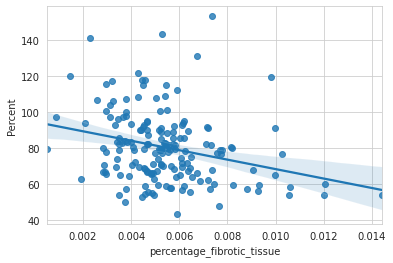

In [10]:
df_unique_patients = df_unique_patients.drop(df_unique_patients[df_unique_patients.lung_volume_cm3 > 20000].index)
df_unique_patients = df_unique_patients[~df_unique_patients.isin([np.nan, np.inf, -np.inf]).any(1)]
df_unique_patients.dropna(inplace=True)
print('Length cleaned Dataframe:', len(df_unique_patients))
sns.regplot(x='percentage_fibrotic_tissue', y='Percent',data=df_unique_patients)
plt.show()


In [11]:
df_unique_patients.describe(include='all')

,First_Week,FVC_First,FVC_Last,Diff_FVC_Abs,Gradient_Coef,Max_FVC,Min_FVC,Std_FVC,Percent,Age,Sex,SmokingStatus,dcm_path,Male,Female,NeverSmoked,ExSmoker,CurrentlySmokes,lung_volume_cm3,percentage_fibrotic_tissue
count,173.0,173.0,173.0,173.0,173.000000,173.0,173.0,173.000000,173.000000,173.0,173,173,173,173.0,173.0,173.0,173.0,173.0,173.000000,173.000000
unique,50.0,166.0,166.0,167.0,NaN,166.0,167.0,NaN,NaN,34.0,2,3,173,2.0,2.0,2.0,2.0,2.0,NaN,NaN
top,0.0,3107.0,2232.0,-58.0,NaN,2914.0,2134.0,NaN,NaN,65.0,Male,Ex-smoker,../input/osic-pulmonary-fibrosis-progression/t...,1.0,0.0,0.0,1.0,0.0,NaN,NaN
freq,17.0,2.0,2.0,2.0,NaN,2.0,2.0,NaN,NaN,15.0,137,115,1,137.0,137.0,124.0,115.0,164.0,NaN,NaN
mean,NaN,NaN,NaN,NaN,-4.532020,NaN,NaN,155.666513,80.323642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7238.445087,0.005406
std,NaN,NaN,NaN,NaN,6.178786,NaN,NaN,92.180433,19.504448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3334.242936,0.002064
min,NaN,NaN,NaN,NaN,-28.182575,NaN,NaN,31.213423,43.352279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,646.000000,0.000517
25%,NaN,NaN,NaN,NaN,-7.617220,NaN,NaN,96.154968,66.249410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4709.000000,0.004115
50%,NaN,NaN,NaN,NaN,-3.873737,NaN,NaN,130.629725,78.896910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7204.000000,0.005224
75%,NaN,NaN,NaN,NaN,-0.956803,NaN,NaN,184.640191,91.171429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9380.000000,0.006200


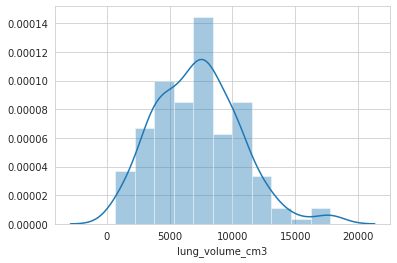

In [12]:
sns.distplot(df_unique_patients.lung_volume_cm3)
plt.show()

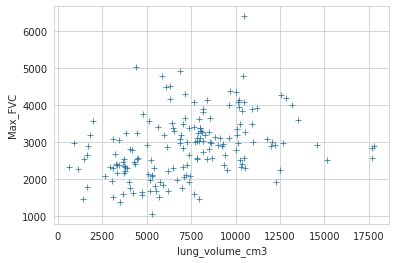

In [13]:
df_modified = df_unique_patients.copy()
sns.scatterplot(x='lung_volume_cm3', y='Max_FVC' ,data=df_modified, marker="+")
plt.show()

ID00419637202311204720264
ID00421637202311550012437
ID00422637202311677017371
ID00423637202312137826377
ID00426637202313170790466


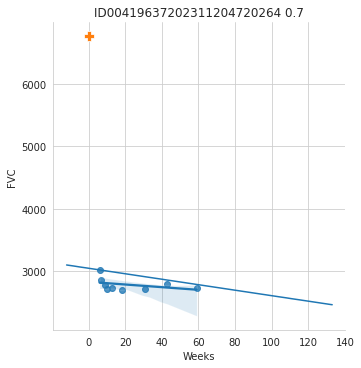

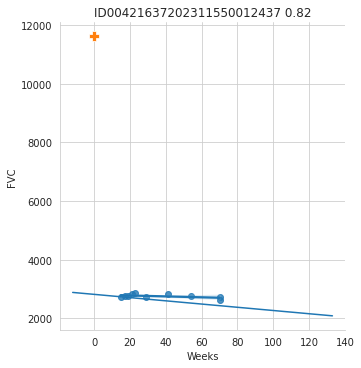

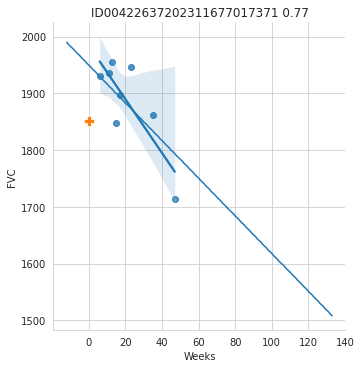

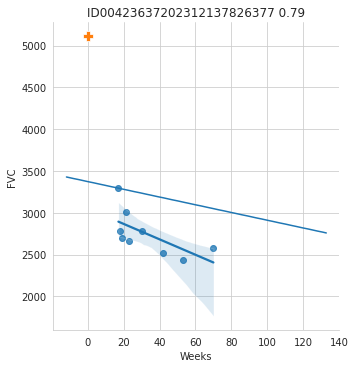

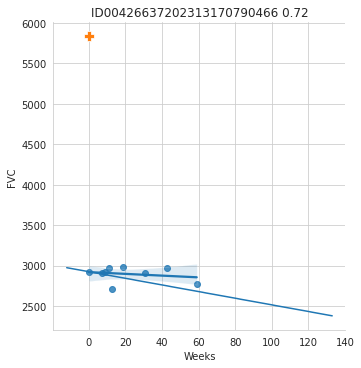

In [14]:
p_id = list(df_test.Patient)
for patient in p_id:
    print(patient)
    lung_volume_cm3 = df_unique_patients[df_unique_patients.index.str.startswith(patient)]['lung_volume_cm3']
    residual_vol_factor = 0.8
    percent = df_unique_patients[df_unique_patients.index.str.startswith(patient)]['Percent'] / 100
    lung_volume = lung_volume_cm3 * residual_vol_factor * percent
    x1 = range(-12, 134, 1)
    y1 = df_submission[df_submission.Patient_Week.str.startswith(patient)]['FVC'].values
    y1 = [int(i) for i in y1]
    sns.lmplot(x = "Weeks", y = "FVC", data = df_train[df_train.Patient == patient])
    sns.lineplot(x = x1, y = y1)
    sns.scatterplot(x=[0], y=lung_volume, marker="P", s=100)
    plt.title(patient + ' ' +str(np.round(percent[0], 2)))
    plt.show()

In [15]:
# patient_id = 'ID00426637202313170790466'
# patient_path = df_train[df_train.Patient == patient_id].dcm_path.values[0]
# slices, slice_factor = load_scans(patient_path)
# hu_scans = transform_to_hu(slices)
# segmented_lungs, masks = segment_lung_mask(hu_scans)
# fig, ax = plt.subplots(6,5, figsize=(20,20))
# for n in range(6):
#     for m in range(5):
#         # ax[n,m].imshow(set_manual_window(segmented_lungs[(n+1)*5+m], 40, 10), cmap="Blues_r")
#         # ax[n,m].imshow(set_manual_window(segmented_lungs[(n+1)*5+m], -700, 255), cmap="Blues_r")
#         ax[n,m].imshow(masks[(n+1)*5+m], cmap="Blues_r")